In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from loader import hetero_graph_loader
import numpy as np 
import matplotlib.pyplot as plt
import torch

from graph_plotting import graph_2D

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from models import graph_classifier, gnn_models
from torch_geometric.loader import DataLoader

from utils import prep
from evaluation import evaluation
from graph_plotting import graph_2D


In [3]:
run = wandb.init(project="graph_pathology")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: luxtu. Use `wandb login --relogin` to force relogin


In [4]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 2, "Late NPDR": 2}

vessel_graph_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_vessel_graph"
void_graph_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_void_graph"
hetero_edges_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_heter_edges"


train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "train",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "test",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

In [5]:
id = "0499_OS"

#g_plotter = graph_2D.HeteroGraphPlotter2D()
#g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], edges=True)
#g_plotter.plot_graph_2D(HeteroDataLoader.hetero_graphs[id], edges=False)

In [6]:
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

node_mean_tensors, node_std_tensors = prep.hetero_graph_normalization_params(train_dataset)
prep.hetero_graph_normalization(train_dataset, node_mean_tensors, node_std_tensors)
prep.hetero_graph_normalization(test_dataset, node_mean_tensors, node_std_tensors)

In [7]:
train_labels = [int(data.y[0]) for data in train_dataset]
class_weights = prep.get_class_weights(train_labels, verbose=False)

In [8]:
num_classes = 3
epochs = 300
node_types = ["graph_1", "graph_2"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the model
model = gnn_models.HeteroGNN(hidden_channels = 64, 
                          out_channels= num_classes, 
                          num_layers= 3, 
                          dropout = 0.2, 
                          aggregation_mode= global_mean_pool,
                          node_types = node_types,
                          )

# create data loaders for training and test set
train_loader = DataLoader(train_dataset.to(device), batch_size = 64, shuffle=True)
test_loader = DataLoader(test_dataset.to(device), batch_size = 1, shuffle=False)


# weigthings for imbalanced classes 
balanced_loss = torch.nn.CrossEntropyLoss(torch.tensor(class_weights).to(device).float())
unbalanced_loss = torch.nn.CrossEntropyLoss() # use when the training data is already balanced


classifier = graph_classifier.graphClassifierHetero(model, train_loader, test_loader, balanced_loss)


for epoch in range(1, epochs+1):
    loss = classifier.train()
    train_acc = classifier.test(train_loader)
    outList, yList = classifier.predict(test_loader)
    #print(outList)
    y_p = np.array([item.argmax().cpu().detach().numpy() for sublist in outList for item in sublist])
    y_t = np.array([item.detach().cpu().numpy() for sublist in yList for item in sublist])
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.6f}, Train Acc: {train_acc:.4f}, Test Acc: {accuracy_score(y_t, y_p):.4f}, Test Bal Acc: {balanced_accuracy_score(y_t, y_p):.4f}')

    wandb.log({"loss": loss, "train_acc": train_acc, "test_acc": accuracy_score(y_t, y_p), "test_bal_acc": balanced_accuracy_score(y_t, y_p)})

    if balanced_accuracy_score(y_t, y_p) > 0.70:
        fig, ax = plt.subplots()
        evaluation.plot_confusion_matrix(y_t, y_p, ["Healthy/DM", "PDR", "NPDR"], ax) # , 3, 4
        plt.show()
        evaluation.plot_roc_curve(y_t, torch.nn.functional.softmax(torch.tensor(np.array(outList).squeeze()), dim = 1), class_labels = ["Healthy/DM", "PDR", "NPDR"]) # , 3, 4
        break



/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


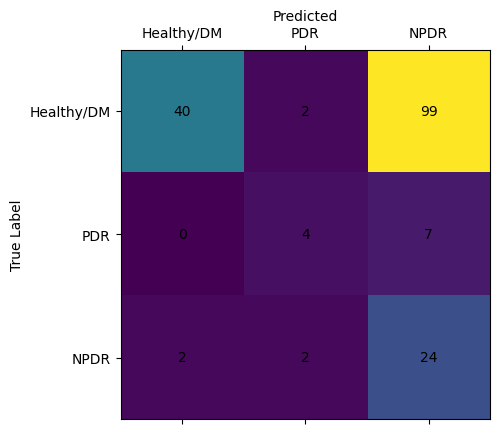

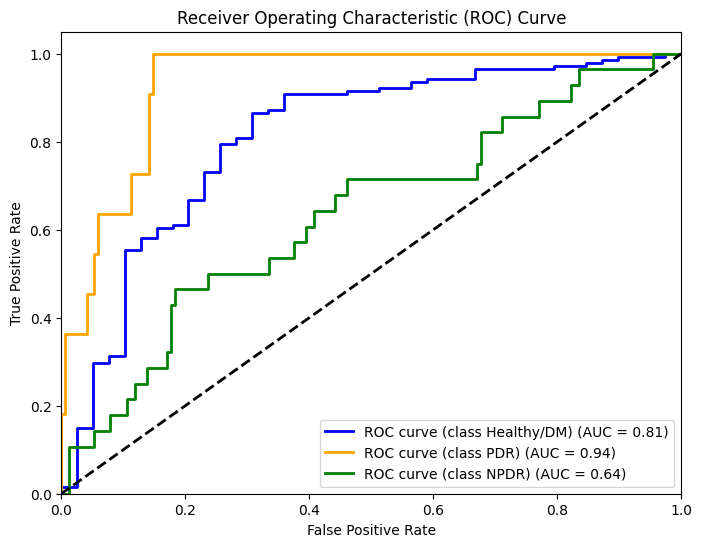

In [9]:
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_t, y_p, ["Healthy/DM", "PDR", "NPDR"], ax) # , 3, 4
plt.show()
evaluation.plot_roc_curve(y_t, torch.nn.functional.softmax(torch.tensor(np.array(outList).squeeze()), dim = 1), class_labels = ["Healthy/DM", "PDR", "NPDR"]) # , 3, 4

In [107]:
graph_1_features = np.array(['centroid-0','centroid-1', 'area','perimeter','eccentricity', 'equivalent_diameter', 'orientation','solidity', 'feret_diameter_max',
                    'extent', 'axis_major_length', 'axis_minor_length', "intensity_max", "intensity_mean","intensity_min", "centroid_weighted-0", "centroid_weighted-1",])

graph_2_features = np.array(["length", "distance", "curveness", "volume", "avgCrossSection", "minRadiusAvg",	"minRadiusStd",	"avgRadiusAvg",	"avgRadiusStd",
                    "maxRadiusAvg", "maxRadiusStd", "roundnessAvg", "roundnessStd", "node1_degree",	"node2_degree",	"num_voxels", "hasNodeAtSampleBorder"])

graph_features = {"graph_1": graph_1_features, "graph_2": graph_2_features}


print(len(graph_1_features))

17


0
0
['intensity_max' 'axis_major_length' 'eccentricity' 'solidity'
 'centroid-1' 'intensity_min' 'extent' 'intensity_mean' 'orientation'
 'centroid-0' 'feret_diameter_max' 'perimeter' 'centroid_weighted-1'
 'centroid_weighted-0'] [1959, 95, 84, 71, 67, 48, 15, 13, 7, 6, 3, 1, 1, 1]
['intensity_max' 'extent' 'equivalent_diameter' 'intensity_mean'
 'centroid-1' 'feret_diameter_max' 'axis_major_length' 'eccentricity'
 'orientation' 'centroid_weighted-1' 'centroid-0' 'perimeter'
 'centroid_weighted-0'] [1999, 74, 74, 70, 65, 47, 14, 10, 7, 5, 3, 2, 1]
['feret_diameter_max' 'intensity_mean' 'axis_minor_length' 'intensity_max'
 'centroid-1' 'orientation' 'eccentricity' 'intensity_min'
 'axis_major_length' 'perimeter' 'equivalent_diameter'
 'centroid_weighted-1' 'extent' 'centroid-0' 'centroid_weighted-0'] [1717, 167, 151, 84, 80, 76, 29, 19, 15, 13, 8, 7, 2, 2, 1]
['curveness' 'hasNodeAtSampleBorder' 'distance' 'num_voxels' 'length'
 'volume'] [113, 61, 55, 53, 41, 3]
['curveness' 'hasNodeAt

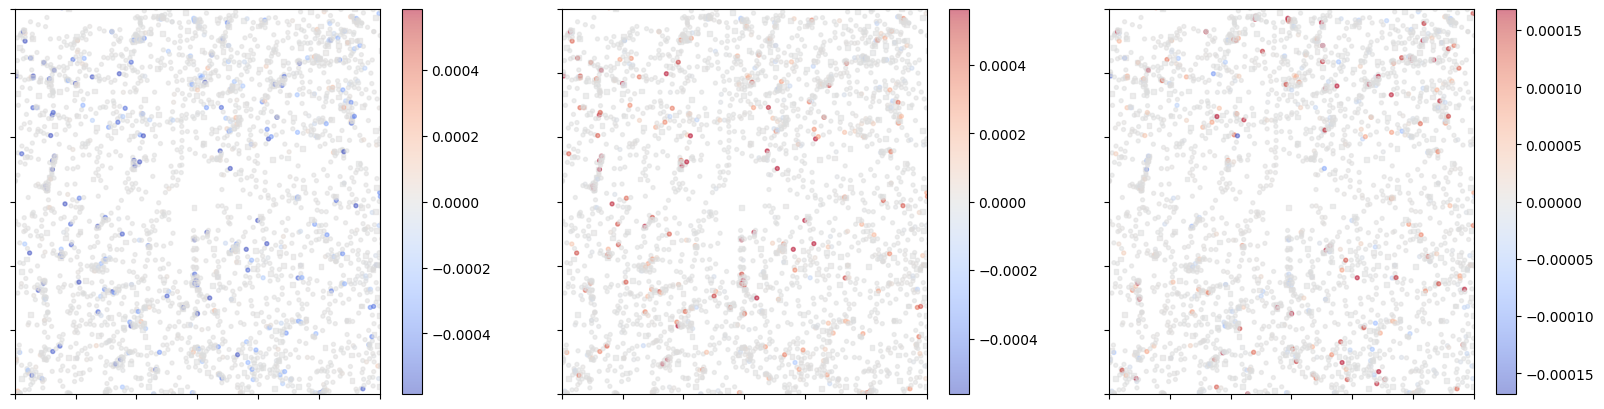

In [153]:
obj_idx = 50
check_object = test_list_bin[obj_idx]
print(y_p[obj_idx])
print(y_t[obj_idx])

for key, val in check_object.x_dict.items():
    val.requires_grad_(True)


initial_scores = model(check_object.x_dict, check_object.edge_index_dict, None)

pred_val_dict = {}
for key, val in check_object.x_dict.items():
    pred_val_dict[key] = torch.zeros(val.shape[0], 3)
    for i in range(3):
        feature_grads = torch.autograd.grad(outputs=initial_scores[:,i], 
                                                        inputs=val, 
                                                        grad_outputs=torch.ones_like(initial_scores[:,i]), 
                                                        retain_graph=True)[0]
        pred_val_dict[key][:,i] = feature_grads.mean(1)
        # get the most important nodes
        idx = np.argmax(feature_grads.mean(1).cpu().detach().numpy(), axis=0)
        # get the gradient of the most important node
        #print(feature_grads[idx,:].cpu().detach().numpy())
        ### get the gradient of some random node
        #print(feature_grads[50,:].cpu().detach().numpy())

        un_vals, cts = np.unique(feature_grads.abs().argmax(1).cpu().detach().numpy(), return_counts=True)
        # sort un_vals by cts
        un_vals = un_vals[-np.argsort(cts)]
        print(graph_features[key][un_vals], sorted(cts, reverse=True))
    
    
fig, ax = plt.subplots(1,3, figsize=(20,5))
g_plotter = graph_2D.HeteroGraphPlotter2D()
g_plotter.set_cls(0)
g_plotter.plot_graph_2D(check_object, pred_val_dict=pred_val_dict, edges=False, ax = ax[0])
g_plotter.set_cls(1)
g_plotter.plot_graph_2D(check_object, pred_val_dict=pred_val_dict, edges=False, ax = ax[1])
g_plotter.set_cls(2)
g_plotter.plot_graph_2D(check_object, pred_val_dict=pred_val_dict, edges=False, ax = ax[2])